In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

%matplotlib inline
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

hp = pd.read_csv("./data/HousePrice2.csv", index_col = 0)
hp_res= hp[hp['MSZoning'].isin(['FV','RH','RL','RM'])]
hp_res = hp_res.dropna()
hp_res.shape

Current working directory: /Users/chereowang27/NYCDSA/Machine_Learning_I/Machine_Learning_Project/Ames_Housing_ML


(2530, 83)

In [2]:
hp_res1 = hp_res.drop(['MapRefNo','PID', 'Prop_Addr'], \
                               axis = 1)
num_features = hp_res1._get_numeric_data()  \
 .drop(['MSSubClass','latitude','longitude','Unnamed: 0.1'], axis = 1)
num_features['bath'] = num_features['FullBath'] + 0.5*num_features['HalfBath']
numCol = num_features.columns

In [3]:
col = hp_res1.columns
catCol = [col for col in hp_res1.columns if col not in num_features.columns]
cat_features = hp_res[catCol].drop(['address', 'latitude', 'longitude','Unnamed: 0.1'],axis = 1)
cat_features.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [4]:
features = pd.concat([num_features, cat_features], axis = 1) \
           .drop(['FullBath', 'HalfBath', \
                  'BsmtFullBath', 'BsmtHalfBath', \
                  'BsmtFinSF1','SalePrice','ExterQual', \
                  'Condition1','Condition2', \
                  'BsmtFinType1','BsmtFinType2', \
                  'BsmtQual', 'GarageQual','MoSold',   \
                  'BsmtFinSF2', 'BsmtUnfSF'],axis = 1)

In [5]:
nb = features['Neighborhood'].unique()
def label_nb(row):
    if row['Neighborhood'] in (['NridgHt','NoRidge','Veenker','StoneBr']):      
        return 'N'
    if row['Neighborhood']      \
             in (['Blmngtn','Gilbert','OldTown', 'NWAmes','NAmes','Blmngtn','BrDale','Somerst','BrkSide','Greens','NPkVill']):
        return 'NE'
    if row['Neighborhood']      \
            in (['CollgCr','SWISU', 'Edwards','SawyerW','Sawyer','ClearCr']):
        return 'W'                      
    if row['Neighborhood'] in (['Crawfor','MeadowV','Timber','Mitchel','IDOTRR']):     
        return 'S'
    
features['Location']=features.apply(lambda row: label_nb(row), axis = 1)
features = features.drop(['Neighborhood'], axis = 1)
features1 = features    

In [6]:
catCol = [col for col in features.columns if col not in num_features.columns]
features= pd.get_dummies(features, columns = catCol, drop_first = True)

y = hp_res['SalePrice']
hp_res['log_Price'] = np.log10(hp_res['SalePrice'])
logy = hp_res['log_Price']

In [7]:
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

lasso = Lasso()

from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3, random_state = 0)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(features, logy, test_size = 0.3, random_state = 0)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lasso_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('lasso',lasso)
])
params = {
#     'lasso__alpha': [0.0001, 0.001, 0.1, 1, 10]      .001
#     'lasso__alpha': np.logspace(-4,-3,100)        # .001
        'lasso__alpha': np.linspace(.0013,.0016,1000)
#    'lasso_max_iter': linspace,
     }
kfold = KFold(n_splits = 3, shuffle = True)
gs_ls = GridSearchCV(lasso_pipe, param_grid = params, scoring = 'r2', cv = kfold)

start = time.time()
gs_ls.fit(X_train_log, y_train_log)
print("Estimator which gave the highest score: ", gs_ls.best_estimator_)
print("Mean cross-validated score of the best_estimator: ", gs_ls.best_score_)
print("The best parameters are: ", gs_ls.best_params_)

Estimator which gave the highest score:  Pipeline(steps=[('standardize', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0.0014555555555555556, max_iter=10000, tol=0.01))])
Mean cross-validated score of the best_estimator:  0.9074422821711318
The best parameters are:  {'lasso__alpha': 0.0014555555555555556}


In [21]:
# Run Lasso Regression with the best alpha from Grid search .001

#for alpha in alphas:
lasso.set_params(alpha = .0015, tol = .01, max_iter = 10000)
lasso.fit(X_train_log, y_train_log)
lasso_coefs = dict(zip(features.columns, lasso.coef_))
lasso_coefs

lasso_coefs_keep = {k:v for (k,v) in lasso_coefs.items() if v !=0}
lasso_coefs_keep
 

{'GrLivArea': 0.00012171127550548037,
 'LotFrontage': 0.0003332112663752374,
 'LotArea': 1.196635747751593e-06,
 'OverallQual': 0.03138576778530436,
 'OverallCond': 0.023027997116971635,
 'YearBuilt': 0.0013138406610339415,
 'YearRemodAdd': 0.00046254228875288887,
 'MasVnrArea': 1.1260242907763472e-05,
 'TotalBsmtSF': 6.589563036997455e-05,
 '1stFlrSF': 2.6511892437137288e-06,
 '2ndFlrSF': 1.4933206450628223e-09,
 'LowQualFinSF': -5.6914973119503344e-05,
 'BedroomAbvGr': -0.008374546346828738,
 'Fireplaces': 0.014304033076294376,
 'GarageYrBlt': 1.1864977026590768e-05,
 'GarageArea': 5.509937912532102e-05,
 'WoodDeckSF': 3.98534244379442e-05,
 'OpenPorchSF': 1.9497756371451582e-05,
 'EnclosedPorch': 8.434888229392245e-05,
 '3SsnPorch': -2.926530054778392e-06,
 'ScreenPorch': 0.0001357382200942097,
 'PoolArea': -7.92526029573471e-05,
 'MiscVal': -1.0361710204060007e-06,
 'YrSold': -0.0007596943720497695,
 'MSZoning_RM': -0.020956953292128624,
 'Foundation_PConc': 0.005469680064167317,
 

In [10]:
lasso.score(X_train_log, y_train_log)

0.9054397480279349

In [11]:
lasso.score(X_test_log, y_test_log)

0.9134554413498921

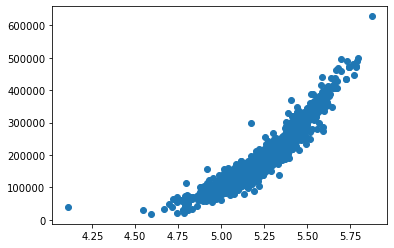

In [35]:
lasso_predicted = lasso.predict(features)



In [41]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv = 3, random_state = 0).fit(features, logy)
reg.path


<function sklearn.linear_model._coordinate_descent.lasso_path(X, y, *, eps=0.001, n_alphas=100, alphas=None, precompute='auto', Xy=None, copy_X=True, coef_init=None, verbose=False, return_n_iter=False, positive=False, **params)>